In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '1'
import glob
import sys
sys.path.append(os.path.join(os.getcwd(), *tuple(['..'])))
import argparse

from typing import Callable, Dict, List, Optional, Set
from collections import OrderedDict
import pdb
import numpy as np
import torch
from models_pytorch_lightning.model_mrcnn_config import _default_mrcnn_config, build_default
from features import build_features
from models_pytorch_lightning.generalized_mask_rcnn_pl import LitMaskRCNN
from utils.helper_functions import evaluate_metrics, get_outputs, compute_iou, evaluate_mask_rcnn
from features import build_features
from features import build_features
from features import transforms as T
#from utils.engine import evaluate
import torchvision
from utils.helper_functions import evaluate_metrics, get_outputs, compute_iou, evaluate_mask_rcnn
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support
from lightning.pytorch.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import plotly.graph_objects as go
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
import plotly.graph_objects as go
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import visualize_output

In [2]:
colors={"Cored":"royalblue", "Diffuse":"firebrick","Coarse-Grained":"orange","CAA":"green"}
class_names = ["Cored","Diffuse","Coarse-Grained","CAA"]

test_config = dict(
    batch_size = 2,
    num_classes=4,
    device_id =0
)
#model_name = "/home/mahirwar/Desktop/Monika/npsad_data/vivek/runpod_mrcnn_models/270ij5uq_epoch_66_step_800.ckpt"
#model_name = "/home/mahirwar/Desktop/Monika/npsad_data/vivek/runpod_mrcnn_models/1i4pfmil-epoch=59-step=720.ckpt"
#model_name = "/home/mahirwar/Desktop/Monika/npsad_data/vivek/runpod_mrcnn_models/2ufah260-epoch=49-step=600.ckpt"
model_name = "/home/mahirwar/Desktop/Monika/npsad_data/vivek/runpod_mrcnn_models/csvy8yix_epoch=31-step=384.ckpt"
#model_name = "/home/mahirwar/Desktop/Monika/npsad_data/vivek/runpod_mrcnn_models/ha0c9pja_epoch=7-step=88.ckpt"
#model_name = "/home/mahirwar/Desktop/Monika/npsad_data/vivek/runpod_mrcnn_models/3pvj7tcu_epoch=55-step=616.ckpt"
model_name = "/home/mahirwar/Desktop/Monika/npsad_data/vivek/runpod_mrcnn_models/cnf1sro4_epoch=68-step=690.ckpt"
model_name = "/home/mahirwar/Desktop/Monika/npsad_data/vivek/runpod_mrcnn_models/2vorciwh_epoch=14-step=240.ckpt"
model_name = "/home/mahirwar/Desktop/Monika/npsad_data/vivek/runpod_mrcnn_models/1qmp7uqp_epoch=32-step=528.ckpt"
model_name = "/home/mahirwar/Desktop/Monika/npsad_data/vivek/runpod_mrcnn_models/3kw68a8y_epoch=52-step=848.ckpt"
model_name= "/home/mahirwar/Desktop/Monika/npsad_data/vivek/runpod_mrcnn_models/3fw50aml_epoch=35-step=576.ckpt"
model_name= "/home/mahirwar/Desktop/Monika/npsad_data/vivek/runpod_mrcnn_models/yp2mf3i8_epoch=108-step=872.ckpt"
model_config = _default_mrcnn_config(num_classes=1 + test_config['num_classes']).config
backbone, rpn, roi_heads, transform1 = build_default(model_config, im_size=1024)

optim_config = dict(
    cls=torch.optim.Adam,
    defaults=dict(lr=0.00001,weight_decay=1e-6) 
)

model = LitMaskRCNN.load_from_checkpoint(model_name)


/home/mahirwar/miniconda3/envs/kfold_amy_plaque1/lib/python3.9/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'backbone_name' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/home/mahirwar/miniconda3/envs/kfold_amy_plaque1/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mahirwar/miniconda3/envs/kfold_amy_plaque1/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt101_32X8D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt101_32X8D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(ms

In [3]:
device = torch.device('cuda', test_config['device_id'])
model = model.to(device)
model.eval()

LitMaskRCNN(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256,

In [4]:
def compute_overlaps_masks(masks1, masks2):
    """Computes IoU overlaps between two sets of masks.
    masks1, masks2: [Height, Width, instances]
    """
    
    # If either set of masks is empty return empty result
    if masks1.shape[-1] == 0 or masks2.shape[-1] == 0:
        return np.zeros((masks1.shape[-1], masks2.shape[-1]))
    # flatten masks and compute their areas
    masks1 = np.reshape(masks1 > .5, (-1, masks1.shape[-1])).astype(np.float32)
    masks2 = np.reshape(masks2 > .5, (-1, masks2.shape[-1])).astype(np.float32)
    area1 = np.sum(masks1, axis=0)
    area2 = np.sum(masks2, axis=0)
    #print(masks1.shape, masks2.shape)
    #print(area1,area2)
    # intersections and union
    intersections = np.dot(masks1.T, masks2)
    union = area1[:, None] + area2[None, :] - intersections
    overlaps = intersections / union

    return overlaps

def trim_zeros(x):
    """It's common to have tensors larger than the available data and
    pad with zeros. This function removes rows that are all zeros.

    x: [rows, columns].
    """
    assert len(x.shape) == 2
    return x[~np.all(x == 0, axis=1)]


def compute_matches(gt_boxes, gt_class_ids, gt_masks,
                    pred_boxes, pred_class_ids, pred_scores, pred_masks,
                    iou_threshold=0.5, score_threshold=0.0):
    """Finds matches between prediction and ground truth instances.

    Returns:
        gt_match: 1-D array. For each GT box it has the index of the matched
                  predicted box.
        pred_match: 1-D array. For each predicted box, it has the index of
                    the matched ground truth box.
        overlaps: [pred_boxes, gt_boxes] IoU overlaps.
    """
    # Trim zero padding
    # TODO: cleaner to do zero unpadding upstream
    #print(pred_masks.shape)
    #print(gt_masks.shape)
    gt_boxes = trim_zeros(gt_boxes)
    gt_masks = gt_masks[..., :gt_boxes.shape[0]]
    pred_boxes = trim_zeros(pred_boxes)
    pred_scores = pred_scores[:pred_boxes.shape[0]]
    # Sort predictions by score from high to low
    indices = np.argsort(pred_scores)[::-1]
    pred_boxes = pred_boxes[indices]
    pred_class_ids = pred_class_ids[indices]
    pred_scores = pred_scores[indices]
    pred_masks = pred_masks[..., indices]
    #gt_masks = gt_masks[..., :gt_boxes.shape[0]]
    #print(pred_masks.shape)
    #print(gt_masks.shape)
    overlap_matrix = np.zeros((len(pred_masks),len(gt_masks)))
    overlaps = compute_overlaps_masks(pred_masks, gt_masks)
    #print(overlaps)
    """
    # Compute IoU overlaps [pred_masks, gt_masks]
    for k in range(len(pred_masks)):
        for l in range(len(gt_masks)):
            print(pred_masks[k].shape)
            print(gt_masks[l].shape)
            overlaps = compute_overlaps_masks(pred_masks[k], gt_masks[l])
            print(overlaps)
            overlap_matrix[k,l]=overlaps
    """
    # Loop through predictions and find matching ground truth boxes
    match_count = 0
    pred_match = -1 * np.ones([pred_boxes.shape[0]])
    gt_match = -1 * np.ones([gt_boxes.shape[0]])
    class_match = -1 * np.ones([pred_boxes.shape[0]])
    
    for i in range(len(pred_boxes)):
        # Find best matching ground truth box
        # 1. Sort matches by score
        sorted_ixs = np.argsort(overlaps[i])[::-1]
        # 2. Remove low scores
        #print ("overlaps[i, sorted_ixs]",overlaps[i, sorted_ixs])
        low_score_idx = np.where(overlaps[i, sorted_ixs] < 0)[0]
        low_score_idx = pred_scores[pred_scores< score_threshold]
        #print(low_score_idx)
        if low_score_idx.size > 0:
            sorted_ixs = sorted_ixs[:low_score_idx[0]]
        # 3. Find the match
        for j in sorted_ixs:
            # If ground truth box is already matched, go to next one
            if gt_match[j] > -1:
                continue
            # If we reach IoU smaller than the threshold, end the loop
            iou = overlaps[i, j]
            if iou < iou_threshold:
                break
            # Do we have a match?
            if pred_class_ids[i] == gt_class_ids[j]:
                match_count += 1
                gt_match[j] = i
                pred_match[i] = j
                #class_match[i]= gt_class_ids[j]
                break

    return pred_scores, gt_match, pred_match, overlaps, class_match, gt_class_ids,pred_class_ids,pred_boxes


def compute_ap(gt_boxes, gt_class_ids, gt_masks,
               pred_boxes, pred_class_ids, pred_scores, pred_masks,
               iou_threshold=0.5):
    """Compute Average Precision at a set IoU threshold (default 0.5).

    Returns:
    mAP: Mean Average Precision
    precisions: List of precisions at different class score thresholds.
    recalls: List of recall values at different class score thresholds.
    overlaps: [pred_boxes, gt_boxes] IoU overlaps.
    """
    # Get matches and overlaps
    pred_scores, gt_match, pred_match, overlaps = compute_matches(
        gt_boxes, gt_class_ids, gt_masks,
        pred_boxes, pred_class_ids, pred_scores, pred_masks,
        iou_threshold)

    # Compute precision and recall at each prediction box step
    precisions = np.cumsum(pred_match > -1) / (np.arange(len(pred_match)) + 1)
    recalls = np.cumsum(pred_match > -1).astype(np.float32) / len(gt_match)

    # Pad with start and end values to simplify the math
    precisions = np.concatenate([[0], precisions, [0]])
    recalls = np.concatenate([[0], recalls, [1]])

    # Ensure precision values decrease but don't increase. This way, the
    # precision value at each recall threshold is the maximum it can be
    # for all following recall thresholds, as specified by the VOC paper.
    for i in range(len(precisions) - 2, -1, -1):
        precisions[i] = np.maximum(precisions[i], precisions[i + 1])

    # Compute mean AP over recall range
    indices = np.where(recalls[:-1] != recalls[1:])[0] + 1
    mAP = np.sum((recalls[indices] - recalls[indices - 1]) *
                 precisions[indices])

    return mAP, precisions, recalls, overlaps

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.squeeze()
    print(inp.shape)
    #inp = inp.numpy().transpose((0, 3, 2, 1))
    inp = inp.numpy().transpose((1, 2, 0))
    
    print(inp.shape)
    mean=np.array([0.8883, 0.8769, 0.8431]),
    std=np.array([0.1425, 0.1589, 0.2029]),
    #mean = np.array([0.485, 0.456, 0.406])
    #std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [6]:
class_names

['Cored', 'Diffuse', 'Coarse-Grained', 'CAA']

In [11]:
precisions = np.zeros([2, 4])
recalls = np.zeros([2, 4])
f1_scores =np.zeros([2, 4])
thresholds =  np.linspace(0.01, 0.95,10) # 0.01 step size, 100 points
thresholds = np.array([0.5,0.7])

for idx, threshold in enumerate(thresholds):
    print("--------------threshold---------------",threshold )
    predictions = []
    matches = []
    gt_all = []
    cored_gt, diffuse_gt,cg_gt, caa_gt  = 0,0,0,0
    cored_pred, diffuse_pred,cg_pred, caa_pred  = 0,0,0,0
    cored_matched, diffuse_matched,cg_matched, caa_matched  = 0,0,0,0
    #gt = {"1":0, "2":0, "3":0,"4":0}
    gt = {1:0, 2:0, 3:0,4:0}
    pred =  {1:0, 2:0, 3:0,4:0}
    matched = {1:0, 2:0, 3:0,4:0}
    precision_dict = {1:0, 2:0, 3:0,4:0}
    recall_dict = {1:0, 2:0, 3:0,4:0}
    
    #iou_overlap = []
    #pred_scores = []
    
    collate_fn=lambda x: tuple(zip(*x))
        #exp_name = run.name
    dataset_test_location = '/home/mahirwar/Desktop/Monika/npsad_data/vivek/Datasets/amyb_wsi_v2/test'
    dataset_test_location = '/home/mahirwar/Desktop/Monika/npsad_data/vivek/Datasets/amyb_wsi_v2/interater_data/monika-rater'
    #dataset_val_location = '/home/mahirwar/Desktop/Monika/npsad_data/vivek/Datasets/amyb_wsi_v2/val'
    test_folders = glob.glob(os.path.join(dataset_test_location, "*"))
    #pred_scores_list, gt_match_list , pred_match_list, overlaps_list = [],[],[],[]
    for test_folder in test_folders:
    #test_folder = test_folders[2]
        test_dataset = build_features.AmyBDataset(os.path.join(dataset_test_location,test_folder), T.Compose([T.ToTensor()]))
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_config['batch_size'], shuffle=False, num_workers=4, collate_fn=collate_fn)
        print(test_folder)
        for i, (images, targets) in enumerate(test_loader):
            images = [image.to(device) for image in images]
            targets = [dict([(k, v.to(device)) for k, v in target.items()]) for target in targets]
            outputs = model.forward(images, targets)
            #print(outputs)
            #print(outputs)
            
            
            for i in range(len(images)):
                gt_boxes = targets[i]["boxes"].cpu().detach().numpy() 
                gt_class_ids = targets[i]["labels"].cpu().detach().numpy()
                gt_masks = targets[i]["masks"].permute(2, 1, 0)
                gt_masks = gt_masks.cpu().detach().numpy()

                

                pred_boxes =outputs[i]["boxes"].cpu().detach().numpy()
                pred_class_ids = outputs[i]["labels"].cpu().detach().numpy()
                pred_scores = outputs[i]["scores"].cpu().detach().numpy()
                pred_masks = outputs[i]["masks"][pred_scores>=threshold]
                
                pred_masks=pred_masks.squeeze(1).permute(2, 1, 0)
                pred_masks = pred_masks.cpu().detach().numpy()
                #print(pred_masks.shape)
            
                
                
                pred_boxes =pred_boxes[pred_scores>=threshold]
                pred_class_ids = pred_class_ids[pred_scores>=threshold]
                pred_scores = pred_scores[pred_scores>=threshold]
                #print(pred_scores.shape)
                
                #pred_masks = pred_masks.cpu().detach().numpy()
                

                #red_masks = pred_masks.reshape((pred_masks.shape[2],pred_masks.shape[3], pred_masks.shape[0]))
                #gt_masks = pred_masks.reshape((gt_masks.shape[1],gt_masks.shape[2], gt_masks.shape[0]))
                #print(pred_masks.shape)
                #print(gt_masks.shape)

                pred_scores, gt_match, pred_match, overlaps, class_match, gt_class_ids,pred_class_ids,_ = compute_matches(gt_boxes, gt_class_ids, gt_masks,
                                    pred_boxes, pred_class_ids, pred_scores, pred_masks,
                                    iou_threshold=0.5, score_threshold=0.0)

                
                #print("gt class id",gt_class_ids)
                #print("pred class id",pred_class_ids)
                #print("class matched", class_match)
                #print(pred_score)
                #print(np.sum(pred_score>threshold))
                
                predictions.append(np.sum(pred_scores>=threshold))
                matches.append(np.sum(pred_match!=-1))
                gt_all.append(len(gt_class_ids))
                #gt_class_ids = gt_class_ids[gt_match!=-1]
                #pred_class_id2 = pred_class_ids[pred_match!=-1]
                #pred_class_id2=pred_class_ids[pred_score>=threshold]
                
                #pred_class_id2 = pred_class_ids[pred_match!=-1]
                
                for x in gt_class_ids:
                #    gt[str(int(x))]=gt[str(x)]+1
                    gt[x]=gt[x]+1
                    
                for x in pred_class_ids:
                    pred[x]=pred[x]+1
                
                
                class_match = gt_class_ids[pred_match[pred_match!=-1].astype(int)]
                #print(class_match)
                for x in class_match:
                    matched[int(x)]=matched[int(x)]+1
                    
                if len(class_match)>len(pred_class_ids):
                    #print(pred_score, gt_match, pred_match, overlaps, class_match, gt_class_ids,pred_class_ids)
                    print("class match", class_match)
                    print("pred_class", pred_class_id2)
                    print("gt_class", gt_class_ids)
                    print("pred match", pred_match)
                
                    #pdb.set_trace()
                #iou_overlap.append(overlap[:np.sum(pred_match!=-1)])
                #pred_scores.append(pred_score[pred_score>threshold])
    print("gt",gt)
    print("pred",pred)
    print("matched",matched)
    for i in range(4):         
        #precision_dict[i]=matched[i]/pred[i]
        #recall_dict[i]=matched[i]/gt[i]
        if pred[i+1]!=0:
            precisions[idx, i] = matched[i+1]/pred[i+1]
        else:
            precisions[idx, i] = 0
        if gt[i+1]!=0:
            recalls[idx, i] = matched[i+1]/gt[i+1]
        else:
            recalls[idx, i] = 0
        if (precisions[idx, i]>0) and (recalls[idx, i]>0):
            f1_scores[idx,i] = (2*precisions[idx, i]*recalls[idx, i])/(precisions[idx, i]+recalls[idx, i])
        else:
            f1_scores[idx,i] = 0
            
            
    print("precision", np.sum(matches)/np.sum(predictions))
    print("recall", np.sum(matches)/np.sum(gt_all))
    #precisions.append(np.sum(matches)/np.sum(predictions))
    #recalls.append(np.sum(matches)/np.sum(gt))
    
            
            
            
            #gt_match_list.append(gt_match)
           # pred_match_list.append(pred_match)
            #overlaps_list.append(overlaps)
            #pred_scores_list.append(pred_scores)

--------------threshold--------------- 0.5
/home/mahirwar/Desktop/Monika/npsad_data/vivek/Datasets/amyb_wsi_v2/interater_data/monika-rater/XE19-037_1_AmyB_1


/home/mahirwar/Desktop/Monika/npsad_data/vivek/Datasets/amyb_wsi_v2/interater_data/monika-rater/XE18-003_1_AmyB_1
/home/mahirwar/Desktop/Monika/npsad_data/vivek/Datasets/amyb_wsi_v2/interater_data/monika-rater/XE11-039_1_AmyB_1
/home/mahirwar/Desktop/Monika/npsad_data/vivek/Datasets/amyb_wsi_v2/interater_data/monika-rater/XE07-049_1_AmyB_1
/home/mahirwar/Desktop/Monika/npsad_data/vivek/Datasets/amyb_wsi_v2/interater_data/monika-rater/XE18-066_1_AmyB_1
gt {1: 22, 2: 36, 3: 76, 4: 0}
pred {1: 14, 2: 202, 3: 98, 4: 7}
matched {1: 10, 2: 31, 3: 48, 4: 0}
precision 0.2772585669781931
recall 0.664179104477612
--------------threshold--------------- 0.7
/home/mahirwar/Desktop/Monika/npsad_data/vivek/Datasets/amyb_wsi_v2/interater_data/monika-rater/XE19-037_1_AmyB_1
/home/mahirwar/Desktop/Monika/npsad_data/vivek/Datasets/amyb_wsi_v2/interater_data/monika-rater/XE18-003_1_AmyB_1
/home/mahirwar/Desktop/Monika/npsad_data/vivek/Datasets/amyb_wsi_v2/interater_data/monika-rater/XE11-039_1_AmyB_1
/hom

In [ ]:
[[360.3811  398.5791  586.22534 635.7809 ]
 [ 95.38708 259.3069  191.58649 340.24707]]

In [11]:
precisions = np.zeros([10, 4])
recalls = np.zeros([10, 4])
f1_scores =np.zeros([10, 4])
thresholds =  np.linspace(0.01, 0.95,10) # 0.01 step size, 100 points
#thresholds = np.array([0.25])

for idx, threshold in enumerate(thresholds):
    print("--------------threshold---------------",threshold )
    predictions = []
    matches = []
    gt_all = []
    cored_gt, diffuse_gt,cg_gt, caa_gt  = 0,0,0,0
    cored_pred, diffuse_pred,cg_pred, caa_pred  = 0,0,0,0
    cored_matched, diffuse_matched,cg_matched, caa_matched  = 0,0,0,0
    #gt = {"1":0, "2":0, "3":0,"4":0}
    gt = {1:0, 2:0, 3:0,4:0}
    pred =  {1:0, 2:0, 3:0,4:0}
    matched = {1:0, 2:0, 3:0,4:0}
    precision_dict = {1:0, 2:0, 3:0,4:0}
    recall_dict = {1:0, 2:0, 3:0,4:0}
    
    #iou_overlap = []
    #pred_scores = []
    
    collate_fn=lambda x: tuple(zip(*x))
        #exp_name = run.name
    #dataset_test_location = '/home/mahirwar/Desktop/Monika/npsad_data/vivek/Datasets/amyb_wsi_v2/test'
    dataset_val_location = '/home/mahirwar/Desktop/Monika/npsad_data/vivek/Datasets/amyb_wsi_v2/val'
    test_dataset = build_features.AmyBDataset(dataset_val_location, T.Compose([T.ToTensor()]))
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_config['batch_size'], shuffle=False, num_workers=4, collate_fn=collate_fn)
    #print(test_folder)
    for i, (images, targets) in enumerate(test_loader):
        images = [image.to(device) for image in images]
        targets = [dict([(k, v.to(device)) for k, v in target.items()]) for target in targets]
        outputs = model.forward(images, targets)
            #print(outputs)
            #print(outputs)
            
            
        for i in range(len(images)):
            gt_boxes = targets[i]["boxes"].cpu().detach().numpy() 
            gt_class_ids = targets[i]["labels"].cpu().detach().numpy()
            gt_masks = targets[i]["masks"].permute(2, 1, 0)
            gt_masks = gt_masks.cpu().detach().numpy()

            

            pred_boxes =outputs[i]["boxes"].cpu().detach().numpy()
            pred_class_ids = outputs[i]["labels"].cpu().detach().numpy()
            pred_scores = outputs[i]["scores"].cpu().detach().numpy()
            pred_masks = outputs[i]["masks"][pred_scores>=threshold]
            
            pred_masks=pred_masks.squeeze(1).permute(2, 1, 0)
            pred_masks = pred_masks.cpu().detach().numpy()

            pred_boxes =pred_boxes[pred_scores>=threshold]
            pred_class_ids = pred_class_ids[pred_scores>=threshold]
            pred_scores = pred_scores[pred_scores>=threshold]

            pred_scores, gt_match, pred_match, overlaps, class_match, gt_class_ids,pred_class_ids,_ = compute_matches(gt_boxes, gt_class_ids, gt_masks,
                                pred_boxes, pred_class_ids, pred_scores, pred_masks,
                                iou_threshold=0.5, score_threshold=0.0)
                
            predictions.append(np.sum(pred_scores>=threshold))
            matches.append(np.sum(pred_match!=-1))
            gt_all.append(len(gt_class_ids))
            for x in gt_class_ids:
            #    gt[str(int(x))]=gt[str(x)]+1
                gt[x]=gt[x]+1
                
            for x in pred_class_ids:
                pred[x]=pred[x]+1
                
                
            class_match = gt_class_ids[pred_match[pred_match!=-1].astype(int)]
            #print(class_match)
            for x in class_match:
                matched[int(x)]=matched[int(x)]+1
                
            if len(class_match)>len(pred_class_ids):
                #print(pred_score, gt_match, pred_match, overlaps, class_match, gt_class_ids,pred_class_ids)
                print("class match", class_match)
                print("pred_class", pred_class_id2)
                print("gt_class", gt_class_ids)
                print("pred match", pred_match)
            
    print("gt",gt)
    print("pred",pred)
    print("matched",matched)
    for i in range(4):         
        if pred[i+1]!=0:
            precisions[idx, i] = matched[i+1]/pred[i+1]
        else:
            precisions[idx, i] = 0
        if gt[i+1]!=0:
            recalls[idx, i] = matched[i+1]/gt[i+1]
        else:
            recalls[idx, i] = 0
        if (precisions[idx, i]>0) and (recalls[idx, i]>0):
            f1_scores[idx,i] = (2*precisions[idx, i]*recalls[idx, i])/(precisions[idx, i]+recalls[idx, i])
        else:
            f1_scores[idx,i] = 0
            
            
    print("precision", np.sum(matches)/np.sum(predictions))
    print("recall", np.sum(matches)/np.sum(gt_all))

--------------threshold--------------- 0.01


degenrate boxes /home/mahirwar/Desktop/Monika/npsad_data/vivek/Datasets/amyb_wsi_v2/val/labels/XE19-028_1_AmyB_1_27648x_90018y_mask.png
pos (array([696]), array([196]))
xmax, xmin, ymax,ymin 196 196 696 696
gt {1: 82, 2: 208, 3: 50, 4: 18}
pred {1: 396, 2: 1010, 3: 513, 4: 347}
matched {1: 82, 2: 200, 3: 50, 4: 16}
precision 0.15357458075904679
recall 0.9720670391061452
--------------threshold--------------- 0.11444444444444443
degenrate boxes /home/mahirwar/Desktop/Monika/npsad_data/vivek/Datasets/amyb_wsi_v2/val/labels/XE19-028_1_AmyB_1_27648x_90018y_mask.png
pos (array([696]), array([196]))
xmax, xmin, ymax,ymin 196 196 696 696
gt {1: 82, 2: 208, 3: 50, 4: 18}
pred {1: 271, 2: 728, 3: 290, 4: 119}
matched {1: 82, 2: 191, 3: 50, 4: 16}
precision 0.24076704545454544
recall 0.946927374301676
--------------threshold--------------- 0.21888888888888888
degenrate boxes /home/mahirwar/Desktop/Monika/npsad_data/vivek/Datasets/amyb_wsi_v2/val/labels/XE19-028_1_AmyB_1_27648x_90018y_mask.png
po

In [ ]:
precisions = []
recalls = []
thersholds =  np.linspace(0, 1, 101)
for threshold in thersholds:
    predictions = []
    matches = []
    gt = []
    iou_overlap =[]
    pred_scores =[]
    for pred_score, pred_match, gt_match, overlap in zip(pred_scores_list, pred_match_list, gt_match_list,overlaps_list ):
        predictions.append(np.sum(pred_score>threshold))
        matches.append(np.sum(pred_match!=-1))
        gt.append(len(gt_match))
        iou_overlap.append(overlap[:np.sum(pred_match!=-1)])
        pred_scores.append(pred_score[pred_score>threshold])
    


In [ ]:
[x for x in iou_overlap]

[array([[0.8053513]], dtype=float32),
 array([[0.8670396]], dtype=float32),
 array([[0.8590978]], dtype=float32),
 array([[0.8169849]], dtype=float32),
 array([[0.8154399]], dtype=float32),
 array([[0.852091  , 0.        ],
        [0.        , 0.79526716]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.8347315]], dtype=float32),
 array([[0.76923925]], dtype=float32),
 array([[0.86911076]], dtype=float32),
 array([[0.83644843]], dtype=float32),
 array([[0.8115043]], dtype=float32),
 array([[0.89879715]], dtype=float32),
 array([[0.8528166]], dtype=float32),
 array([[0.8032795]], dtype=float32),
 array([[0.758792]], dtype=float32),
 array([[0.7833321 , 0.        ],
        [0.        , 0.84733325]], dtype=float32),
 array([[0.83974487]], dtype=float32),
 array([[0.8758315]], dtype=float32),
 array([[0.82325727]], dtype=float32),
 array([[0.88081056]], dtype=float32),
 array([[0.8886438]], dtype=float32),
 array([[0.933765]], dtype=float32),
 array([[0.88328797]], dtype=float

In [ ]:
mAP_list =[]
precisions_list=[]
recalls_list =[]

for gt_match, pred_match, overlaps in zip(gt_match_list , pred_match_list, overlaps_list):
    # Compute precision and recall at each prediction box step
    precisions = np.cumsum(pred_match > -1) / (np.arange(len(pred_match)) + 1)
    recalls = np.cumsum(pred_match > -1).astype(np.float32) / len(gt_match)

    # Pad with start and end values to simplify the math
    precisions = np.concatenate([[0], precisions, [0]])
    recalls = np.concatenate([[0], recalls, [1]])

    # Ensure precision values decrease but don't increase. This way, the
    # precision value at each recall threshold is the maximum it can be
    # for all following recall thresholds, as specified by the VOC paper.
    for i in range(len(precisions) - 2, -1, -1):
        precisions[i] = np.maximum(precisions[i], precisions[i + 1])

    # Compute mean AP over recall range
    indices = np.where(recalls[:-1] != recalls[1:])[0] + 1
    mAP = np.sum((recalls[indices] - recalls[indices - 1]) *
                    precisions[indices])

#print("Precision", precisions)
#print("Recall", recalls)
#print("mAP",mAP)
#mAP_list.append(mAP)
#precisions_list.append(precisions)
#recalls_list.append(recalls)

In [ ]:
precisions

array([1. , 1. , 0.5, 0. ])

In [ ]:
recalls

array([0., 1., 1., 1.])

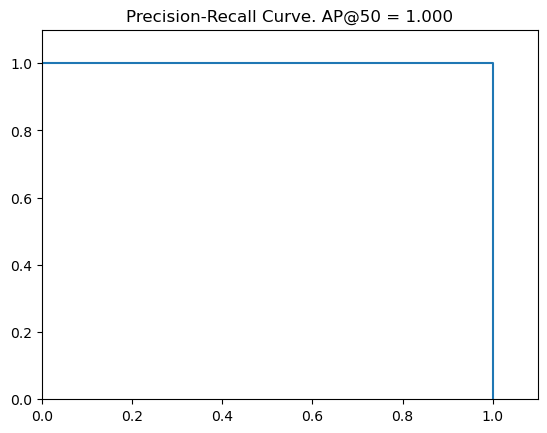

In [ ]:
# Plot the Precision-Recall curve
_, ax = plt.subplots(1)
ax.set_title("Precision-Recall Curve. AP@50 = {:.3f}".format(mAP))
ax.set_ylim(0, 1.1)
ax.set_xlim(0, 1.1)
_ = ax.plot(recalls, precisions)

In [ ]:
mAP

1.0

In [ ]:
import pandas as pd
eval = pd.read_csv("/home/mahirwar/Desktop/Monika/npsad_data/vivek/reports/test-metrics/2ufah260-epoch=49-step=600.ckpt/eval_metrics.csv")
cored = eval[eval["class"]=="Cored"]
import plotly.express as px
fig = px.scatter(x=cored["recall"].values, y=cored["precision"].values)
fig.show()

In [39]:
import cv2
import random
def draw_segmentation_map(image, boxes, gt_labels, pred_labels):
    alpha = 1 
    beta = 0.6 # transparency for the segmentation map
    gamma = 0 # scalar added to each 
    segmentation_map = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
    result_masks = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)

    for i in range(len(boxes)):

        # TODO fix the color segmentation masks
        #red_map = np.zeros_like(masks[i]).astype(np.uint8)
        #green_map = np.zeros_like(masks[i]).astype(np.uint8)
        #blue_map = np.zeros_like(masks[i]).astype(np.uint8)
        
        # apply a randon color mask to each object
        rect_color = (0,0,0)
        colors = np.random.uniform(0, 255, size=(len(class_names), 3))
        color = colors[random.randrange(0, len(colors))]
        #red_map[masks[i] == 1], green_map[masks[i] == 1], blue_map[masks[i] == 1]  = self.class_to_colors[labels[i]]
        #result_masks[masks[i] == 1] = 255
        # combine all the masks into a single image
        # change the format of mask to W,H, C

        # segmentation_map = np.stack([red_map, green_map, blue_map], axis=2)
        #convert the original PIL image into NumPy format
        image = np.array(image)
        # convert from RGB to OpenCV BGR format
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        # apply mask on the image
        # cv2.addWeighted(image, alpha, segmentation_map, beta, gamma, image)
        # draw the bounding boxes around the objects
        cv2.rectangle(image, boxes[i][0], boxes[i][1],
                    thickness=2, color = color)
        # Get the centre coords of the rectangle-plaque-detection/src/visualizat
        x1 = boxes[i][0][0]
        y1 = boxes[i][0][1]
        x2 = boxes[i][1][0]
        y2 = boxes[i][1][1]
        x = int((x1 + x2) / 2)
        y = int((y1+y2) / 2)

        
        # put the label text above the objects
        cv2.putText(image , gt_labels[i]+"_"+ pred_labels[i], (x1, y1-20), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, rect_color, 
                    thickness=2, lineType=cv2.LINE_AA)
        
        # Convert Back
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [40]:
draw_segmentation_map(img, [pred_boxes[0]], ["Cored"], ["Coarse-Grained"])

error: OpenCV(4.9.0) :-1: error: (-5:Bad argument) in function 'rectangle'
> Overload resolution failed:
>  - Can't parse 'pt1'. Input argument doesn't provide sequence protocol
>  - Can't parse 'pt1'. Input argument doesn't provide sequence protocol
>  - argument for rectangle() given by name ('color') and position (3)
>  - argument for rectangle() given by name ('color') and position (3)


In [11]:

from PIL import Image
import cv2

In [12]:
colors = np.random.uniform(0, 255, size=(len(class_names), 3))
color = colors[random.randrange(0, len(colors))]

NameError: name 'random' is not defined

In [13]:
precisions = np.zeros([1, 4])
recalls = np.zeros([1, 4])
f1_scores =np.zeros([1, 4])
thresholds =  np.linspace(0.01, 0.95,100) # 0.01 step size, 100 points
thresholds = np.array([0.25])

for idx, threshold in enumerate(thresholds):
    print("--------------threshold---------------",threshold )
    predictions = []
    matches = []
    gt_all = []
    cored_gt, diffuse_gt,cg_gt, caa_gt  = 0,0,0,0
    cored_pred, diffuse_pred,cg_pred, caa_pred  = 0,0,0,0
    cored_matched, diffuse_matched,cg_matched, caa_matched  = 0,0,0,0
    #gt = {"1":0, "2":0, "3":0,"4":0}
    gt = {1:0, 2:0, 3:0,4:0}
    pred =  {1:0, 2:0, 3:0,4:0}
    matched = {1:0, 2:0, 3:0,4:0}
    precision_dict = {1:0, 2:0, 3:0,4:0}
    recall_dict = {1:0, 2:0, 3:0,4:0}
    collate_fn=lambda x: tuple(zip(*x))
        #exp_name = run.name
    dataset_test_location = '/home/mahirwar/Desktop/Monika/npsad_data/vivek/Datasets/amyb_wsi/test'
    test_folders = glob.glob(os.path.join(dataset_test_location, "*"))
    #pred_scores_list, gt_match_list , pred_match_list, overlaps_list = [],[],[],[]
    for test_folder in test_folders:
    #test_folder = test_folders[2]
        test_dataset = build_features.AmyBDataset(os.path.join(dataset_test_location,test_folder), T.Compose([T.ToTensor()]))
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_config['batch_size'], shuffle=False, num_workers=4, collate_fn=collate_fn)

        for j, (images, targets) in enumerate(test_loader):
            images = [image.to(device) for image in images]
            targets = [dict([(k, v.to(device)) for k, v in target.items()]) for target in targets]
            outputs = model.forward(images, targets)
            
            for i in range(len(images)):
                gt_boxes = targets[i]["boxes"].cpu().detach().numpy() 
                gt_class_ids = targets[i]["labels"].cpu().detach().numpy()
                gt_masks = targets[i]["masks"].permute(2, 1, 0)
                gt_masks = gt_masks.cpu().detach().numpy()
                
                pred_boxes =outputs[i]["boxes"].cpu().detach().numpy()
                pred_class_ids = outputs[i]["labels"].cpu().detach().numpy()
                pred_scores = outputs[i]["scores"].cpu().detach().numpy()
                pred_masks = outputs[i]["masks"][pred_scores>=threshold]
                
                pred_masks=pred_masks.squeeze(1).permute(2, 1, 0)
                pred_masks = pred_masks.cpu().detach().numpy()
                pred_boxes =pred_boxes[pred_scores>=threshold]
                pred_class_ids = pred_class_ids[pred_scores>=threshold]
                pred_scores = pred_scores[pred_scores>=threshold]
                pred_scores, gt_match, pred_match, overlaps, class_match, gt_class_ids,pred_class_ids, pred_boxes = compute_matches(gt_boxes, gt_class_ids, gt_masks,
                                    pred_boxes, pred_class_ids, pred_scores, pred_masks,
                                    iou_threshold=0.5, score_threshold=0.0)

                
                class_mismatch = gt_class_ids[gt_match==-1]
                
                pred_boxes = pred_boxes[pred_match==-1]
               
                pred_class_ids = pred_class_ids[pred_match==-1]
                
                
                print("class_mismatch",class_mismatch)
                print("pred_boxes",len(pred_boxes))
                print("pred_class_ids", pred_class_ids)
                
                img = images[i].permute(1,2,0).cpu().detach().numpy()
                #mean=np.array([0.8883, 0.8769, 0.8431])
                #std=np.array([0.1425, 0.1589, 0.2029])
                #img = std * img + mean
                #img = np.clip(img, 0, 1)
                
                for i in range(len(gt_boxes)):
                    box = gt_boxes[i]
                    cv2.rectangle(img, (int(box[0]),int(box[1])),(int(box[2]),int(box[3])),color = (255, 0, 0) , thickness=2)
                    cv2.putText(img , "gt "+class_names[gt_class_ids[i]-1], (int(box[0]), int(box[1])-20), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), thickness=1, lineType=cv2.LINE_AA)

                
                for i in range(len(pred_boxes)):
                    box = pred_boxes[i]
                    cv2.rectangle(img, (int(box[0]),int(box[1])),(int(box[2]),int(box[3])),color = (0, 0, 0) , thickness=2)
                    if (len(class_mismatch)>i):
                        cv2.putText(img , "pred "+class_names[pred_class_ids[i]-1]+" gt "+class_names[class_mismatch[i]-1], (int(box[0]), int(box[1])-20), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), thickness=1, lineType=cv2.LINE_AA)
                    else:
                        cv2.putText(img , "pred "+class_names[pred_class_ids[i]-1], (int(box[0]), int(box[1])-20), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), thickness=1, lineType=cv2.LINE_AA)
                
                
                
                if len(pred_boxes)>0:
                    im = Image.fromarray((img*255).astype(np.uint8))
                    im.save("/home/mahirwar/Desktop/Monika/npsad_data/vivek/model_analysis/mismatched_images_0.25/"+test_folder.split("/")[-1]+"_"+str(j*2+i)+".png")
                

--------------threshold--------------- 0.25
class_mismatch []
pred_boxes 1
pred_class_ids [1]
class_mismatch []
pred_boxes 2
pred_class_ids [3 1]
class_mismatch []
pred_boxes 2
pred_class_ids [3 1]
class_mismatch []
pred_boxes 0
pred_class_ids []
class_mismatch []
pred_boxes 1
pred_class_ids [1]
class_mismatch []
pred_boxes 1
pred_class_ids [1]
class_mismatch []
pred_boxes 4
pred_class_ids [2 3 2 1]
class_mismatch []
pred_boxes 3
pred_class_ids [3 2 2]
class_mismatch []
pred_boxes 4
pred_class_ids [2 3 2 1]
class_mismatch []
pred_boxes 2
pred_class_ids [3 1]
class_mismatch []
pred_boxes 2
pred_class_ids [3 1]
class_mismatch []
pred_boxes 3
pred_class_ids [2 3 1]
class_mismatch []
pred_boxes 2
pred_class_ids [3 1]
class_mismatch []
pred_boxes 2
pred_class_ids [3 1]
class_mismatch []
pred_boxes 2
pred_class_ids [3 1]
class_mismatch []
pred_boxes 1
pred_class_ids [3]
class_mismatch []
pred_boxes 4
pred_class_ids [2 2 3 2]
class_mismatch []
pred_boxes 2
pred_class_ids [3 2]
class_mismatch 

In [14]:
precisions = np.zeros([1, 4])
recalls = np.zeros([1, 4])
f1_scores =np.zeros([1, 4])
thresholds =  np.linspace(0.01, 0.95,100) # 0.01 step size, 100 points
thresholds = np.array([0.5])
k=0
for idx, threshold in enumerate(thresholds):
    print("--------------threshold---------------",threshold )
    predictions = []
    matches = []
    gt_all = []
    cored_gt, diffuse_gt,cg_gt, caa_gt  = 0,0,0,0
    cored_pred, diffuse_pred,cg_pred, caa_pred  = 0,0,0,0
    cored_matched, diffuse_matched,cg_matched, caa_matched  = 0,0,0,0
    #gt = {"1":0, "2":0, "3":0,"4":0}
    gt = {1:0, 2:0, 3:0,4:0}
    pred =  {1:0, 2:0, 3:0,4:0}
    matched = {1:0, 2:0, 3:0,4:0}
    precision_dict = {1:0, 2:0, 3:0,4:0}
    recall_dict = {1:0, 2:0, 3:0,4:0}
    collate_fn=lambda x: tuple(zip(*x))
        #exp_name = run.name
    dataset_test_location = '/home/mahirwar/Desktop/Monika/npsad_data/vivek/Datasets/amyb_wsi_v2/val'
    #test_folders = glob.glob(os.path.join(dataset_test_location, "*"))
    #pred_scores_list, gt_match_list , pred_match_list, overlaps_list = [],[],[],[]
    #for test_folder in test_folders:
    #test_folder = test_folders[2]
    test_dataset = build_features.AmyBDataset(dataset_test_location, T.Compose([T.ToTensor()]))
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_config['batch_size'], shuffle=False, num_workers=4, collate_fn=collate_fn)

    for j, (images, targets) in enumerate(test_loader):
        images = [image.to(device) for image in images]
        targets = [dict([(k, v.to(device)) for k, v in target.items()]) for target in targets]
        outputs = model.forward(images, targets)
        
        for i in range(len(images)):
            gt_boxes = targets[i]["boxes"].cpu().detach().numpy() 
            gt_class_ids = targets[i]["labels"].cpu().detach().numpy()
            gt_masks = targets[i]["masks"].permute(2, 1, 0)
            gt_masks = gt_masks.cpu().detach().numpy()
            
            pred_boxes =outputs[i]["boxes"].cpu().detach().numpy()
            pred_class_ids = outputs[i]["labels"].cpu().detach().numpy()
            pred_scores = outputs[i]["scores"].cpu().detach().numpy()
            pred_masks = outputs[i]["masks"][pred_scores>=threshold]
            
            pred_masks=pred_masks.squeeze(1).permute(2, 1, 0)
            pred_masks = pred_masks.cpu().detach().numpy()
            pred_boxes =pred_boxes[pred_scores>=threshold]
            pred_class_ids = pred_class_ids[pred_scores>=threshold]
            pred_scores = pred_scores[pred_scores>=threshold]
            pred_scores, gt_match, pred_match, overlaps, class_match, gt_class_ids,pred_class_ids, pred_boxes = compute_matches(gt_boxes, gt_class_ids, gt_masks,
                                pred_boxes, pred_class_ids, pred_scores, pred_masks,
                                iou_threshold=0.5, score_threshold=0.0)

            
            class_mismatch = gt_class_ids[gt_match==-1]
            
            pred_boxes = pred_boxes[pred_match==-1]
            
            pred_class_ids = pred_class_ids[pred_match==-1]
            
            
            print("class_mismatch",class_mismatch)
            print("pred_boxes",len(pred_boxes))
            print("pred_class_ids", pred_class_ids)
            
            img = images[i].permute(1,2,0).cpu().detach().numpy()
            #mean=np.array([0.8883, 0.8769, 0.8431])
            #std=np.array([0.1425, 0.1589, 0.2029])
            #img = std * img + mean
            #img = np.clip(img, 0, 1)
            
            for i in range(len(gt_boxes)):
                box = gt_boxes[i]
                cv2.rectangle(img, (int(box[0]),int(box[1])),(int(box[2]),int(box[3])),color = (255, 0, 0) , thickness=2)
                cv2.putText(img , "gt "+class_names[gt_class_ids[i]-1], (int(box[0]), int(box[1])-20), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), thickness=1, lineType=cv2.LINE_AA)

            
            for i in range(len(pred_boxes)):
                box = pred_boxes[i]
                cv2.rectangle(img, (int(box[0]),int(box[1])),(int(box[2]),int(box[3])),color = (0, 0, 0) , thickness=2)
                if (len(class_mismatch)>i):
                    cv2.putText(img , "pred "+class_names[pred_class_ids[i]-1]+" gt "+class_names[class_mismatch[i]-1], (int(box[0]), int(box[1])-20), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), thickness=1, lineType=cv2.LINE_AA)
                else:
                    cv2.putText(img , "pred "+class_names[pred_class_ids[i]-1], (int(box[0]), int(box[1])-20), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), thickness=1, lineType=cv2.LINE_AA)
            
            
            
            if len(pred_boxes)>0:
                im = Image.fromarray((img*255).astype(np.uint8))
                k=k+1
                im.save("/home/mahirwar/Desktop/Monika/npsad_data/vivek/model_analysis/val_mismatched_images_0.5/"+str(k)+".png")
                

--------------threshold--------------- 0.5


class_mismatch []
pred_boxes 0
pred_class_ids []
class_mismatch []
pred_boxes 0
pred_class_ids []
class_mismatch []
pred_boxes 0
pred_class_ids []
class_mismatch []
pred_boxes 0
pred_class_ids []
class_mismatch []
pred_boxes 0
pred_class_ids []
class_mismatch [2]
pred_boxes 2
pred_class_ids [2 1]
class_mismatch []
pred_boxes 0
pred_class_ids []
class_mismatch [1]
pred_boxes 1
pred_class_ids [3]
class_mismatch []
pred_boxes 1
pred_class_ids [2]
class_mismatch []
pred_boxes 0
pred_class_ids []
class_mismatch []
pred_boxes 0
pred_class_ids []
class_mismatch []
pred_boxes 1
pred_class_ids [2]
class_mismatch []
pred_boxes 0
pred_class_ids []
class_mismatch []
pred_boxes 2
pred_class_ids [2 2]
class_mismatch []
pred_boxes 0
pred_class_ids []
class_mismatch []
pred_boxes 0
pred_class_ids []
class_mismatch []
pred_boxes 0
pred_class_ids []
class_mismatch []
pred_boxes 0
pred_class_ids []
class_mismatch []
pred_boxes 0
pred_class_ids []
class_mismatch []
pred_boxes 1
pred_class_ids [2]
class_mi

: 

In [52]:

for box in pred_boxes:
    cv2.rectangle(img, box[i][0], box[i][1],
                    thickness=2, color = color)

In [65]:
mean=np.array([0.8883, 0.8769, 0.8431])
std=np.array([0.1425, 0.1589, 0.2029])
img = std * img + mean
img = np.clip(img, 0, 1)